## Mount Drive & Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import imutils
import numpy as np
import pandas as pd

### Loading Libraries

In [ ]:
#!pip install opendatasets
#!pip install chart_studio
#!pip install pytesseract 
#!pip install Pillow==9.0.0
#!pip install tesseract
#!sudo apt update
#!sudo apt install tesseract-ocr
#!sudo apt install libtesseract-dev

#########IF WORKING LOCAL ENV#########
#!pip install leptonica
#!pip install tesseract-ocr 
#brew install tesseract #On Mac

In [ ]:
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter
import opendatasets as od
from google.colab import drive

import cv2
import imutils
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.offline import iplot
from wordcloud import WordCloud

from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS

import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/landlord/handwriting-recognition/download", force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xuetingggg
Your Kaggle Key: ··········


100%|██████████| 1.26G/1.26G [00:26<00:00, 51.8MB/s]


#### Clustering By DBSCAN

In [ ]:
train_n_shape = pd.read_csv(filepath + 'train_n_shape.csv', index_col = 0)

In [ ]:
train_n_shape.head()

,FILENAME,IDENTITY,height,width,dim,cluster
0,TRAIN_00006.jpg,lucie,31,284,3,0
1,TRAIN_00011.jpg,emma,44,324,3,1
2,TRAIN_00020.jpg,romain,44,324,3,1
3,TRAIN_00027.jpg,thomas,44,324,3,1
4,TRAIN_00069.jpg,ines,23,388,3,2


In [ ]:
train_n_shape.value_counts('cluster')

cluster
 2    11599
 1     9409
 0     7228
 3     6069
-1        1
dtype: int64

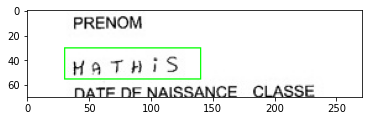

In [ ]:
img_path = file_path_train + 'TRAIN_70176.jpg'
img = cv2.imread(img_path).copy()
cv2.rectangle(img, (30, 30), (140, 55), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img)

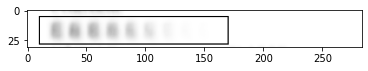

In [ ]:
img0 = cluster_avg[1].copy()
cv2.rectangle(img0, (10, 5), (170, 28), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img0, cmap = 'gray')

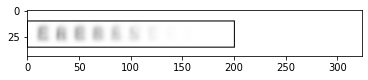

In [ ]:
img1 = cluster_avg[2].copy()
cv2.rectangle(img1, (0, 10), (200, 35), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img1, cmap = 'gray')

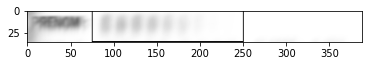

In [ ]:
img2 = cluster_avg[3].copy()
cv2.rectangle(img2, (75, 0), (250, 35), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img2, cmap = 'gray')

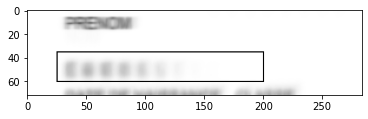

In [ ]:
img3 = cluster_avg[4].copy()
cv2.rectangle(img3, (25, 35), (200, 60), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img3, cmap = 'gray')

Through trail and testing we concluded that the cropping boarders for the five clusers can be ([(30, 30), (140, 55)], [(10, 5), (170, 28)], [(0, 10), (200, 35)], [(75, 0), (250, 35)], [(25, 35), (200, 60)])

In [ ]:
boundary_list = [[(30, 30), (140, 55)], [(10, 5), (170, 28)], [(0, 10), (200, 35)], [(75, 0), (250, 35)], [(25, 35), (200, 60)]]

In [ ]:
boundary_list

[[(30, 30), (140, 55)],
 [(10, 5), (170, 28)],
 [(0, 10), (200, 35)],
 [(75, 0), (250, 35)],
 [(25, 35), (200, 60)]]

In [ ]:
#calculate the cropped image size to decide resize for all images
#get the largest bounding box area
max_width = 0
max_height = 0
for i in boundary_list:
  width = i[1][0] - i[0][0]
  height = i[1][1] - i[0][1]
  if max_width < width:
    max_width = width
  if max_height < height:
    max_height = height
print(max_width)
print(max_height)

200
35


##### DBSCAN Image Cropping

In [ ]:
total=[]
crop_boxes = []
for i in range(0,len(train)):
  img_dir =  file_path_train+train_n_shape.loc[i, 'FILENAME']
  srcImage = Image.open(img_dir)
  cluster = train_n_shape.loc[i, 'cluster']
  image_bx = srcImage.width
  image_by = srcImage.height
  bx = min(boundary_list[cluster+1][1][0], image_bx) 
  by = min(boundary_list[cluster+1][1][1], image_by) #Take image boundary if crop boundary larger than size
  crop_box =  boundary_list[cluster+1][0] + (bx, by)
  crop_boxes.append(crop_box)
  srcImage = srcImage.crop(crop_box)
  srcImage = srcImage.resize((200,35))
  grayImage = srcImage.convert('L')
  binarizedImage = grayImage.point(lambda x: 0 if x<200 else 1, '1')
  pixel = list(binarizedImage.getdata())
  total.append(pixel)

In [ ]:
df_cropped = pd.DataFrame(total)

In [ ]:
df_cropped['IDENTITY'] = train_n_shape.IDENTITY

In [ ]:
#df_cropped.to_csv(filepath + 'df_cropped.csv')

### OCR on train

In [ ]:
train_n_shape = pd.read_csv(filepath + 'train_n_shape.csv', index_col = 0)

In [ ]:
all_text = []
for i in range(train_n_shape.shape[0]):
  org_image_dir =  file_path_train+train_n_shape.loc[i, 'FILENAME']
  org_image = Image.open(org_image_dir)
  crop_dim = crop_boxes[i]
  crop_img = org_image.crop(crop_dim)
  pred_text = pytesseract.image_to_string(crop_img)
  all_text.append(pred_text)

In [ ]:
df_ocr = pd.DataFrame(all_text)

In [ ]:
df_ocr.to_csv(filepath + 'df_ocr.csv')

### Loading Results

In [ ]:
#filepath = '/content/drive/My Drive/ML/Data/Handwriting/'
filepath = '/content/drive/My Drive/MSCA_ML/Final_Project/Data/Handwriting/'

file_path_train = '/content/handwriting-recognition/train_v2/train/'
file_path_test = '/content/handwriting-recognition/test_v2/test/'
file_path_valid = '/content/handwriting-recognition/validation_v2/validation/'

In [ ]:
import pandas as pd 
original = pd.read_csv(filepath + 'train_n_shape.csv', index_col = 0)
result =  pd.read_csv(filepath + 'df_ocr.csv', index_col = 0)

### Dataframe Compiling

In [ ]:
ocr_result = pd.DataFrame(columns = ['true_value', 'pred_value'])
ocr_result['true_value'] = original.IDENTITY
ocr_result['pred_value'] = result
ocr_result['pred_value'] = ocr_result.pred_value.str.lower()

### Result Accuracy

#### Train

Since there exists empty value, we fill the nulls with empty lists.

In [ ]:
ocr_result = ocr_result.fillna('')

Calculating correct rate for prediction and for character in prediction

In [ ]:
correct_char = 0
correct_pred = 0
total_char = 0

for i in range(ocr_result.shape[0]):
    true_name = ocr_result.loc[i, 'true_value']
    pred_name = ocr_result.loc[i, 'pred_value']
    total_char += len(true_name)
    
    for j in range(min(len(true_name), len(pred_name))):
        if pred_name[j] == true_name[j]:
            correct_char += 1
            
    if true_name == pred_name :
        correct_pred += 1 

In [ ]:
#Total correct rate
correct_pred/ocr_result.shape[0] * 100

39.01941351367108

In [ ]:
#Char correct rate
correct_char/ total_char * 100

64.2607998613458

#### Test

In [ ]:
test_n_shape = pd.read_csv(filepath + 'test_n_shape.csv', index_col = 0)

In [ ]:
kmeans_boundary_list = [[(75, 0), (250, 35)], [(0, 10), (200, 40)], [(0, 0), (200, 40)], [(25, 35), (175, 65)]]

In [ ]:
test_n_shape.head()

,FILENAME,IDENTITY,height,width,dim,km_cluser
0,VALIDATION_0003.jpg,lea,31,284,3,1
1,VALIDATION_0016.jpg,antoine,31,284,3,1
2,VALIDATION_0022.jpg,mathis,44,324,3,2
3,VALIDATION_0032.jpg,hugo,30,388,3,0
4,VALIDATION_0039.jpg,clement,31,284,3,1


In [ ]:
test_text = []
for i in range(test_n_shape.shape[0]):
  org_image_dir =  file_path_valid+test_n_shape.loc[i, 'FILENAME']
  org_image = Image.open(org_image_dir)
  cluster_num = test_n_shape.loc[i, 'km_cluser']
  crop_dim = kmeans_boundary_list[cluster_num]
  crop_img = org_image.crop(crop_dim[0] + crop_dim[1])
  pred_text = pytesseract.image_to_string(crop_img)
  test_text.append(pred_text.strip())

In [ ]:
original_test = test_n_shape.IDENTITY

In [ ]:
test_text = list(map(lambda x: x.lower(), test_text))

In [ ]:
ocr_result_test = pd.DataFrame(columns = ['true_value', 'pred_value'])
ocr_result_test['true_value'] = original_test
ocr_result_test['pred_value'] = test_text

In [ ]:
ocr_result_test = ocr_result_test.fillna('')

In [ ]:
correct_char = 0
correct_pred = 0
total_char = 0

for i in range(ocr_result_test.shape[0]):
    true_name = ocr_result_test.loc[i, 'true_value']
    pred_name = ocr_result_test.loc[i, 'pred_value']
    total_char += len(true_name)
    
    for j in range(min(len(true_name), len(pred_name))):
        if pred_name[j] == true_name[j]:
            correct_char += 1
            
    if true_name == pred_name :
        correct_pred += 1 

In [ ]:
ocr_result_test.to_csv('df_ocr_test.csv')

In [ ]:
#Total correct rate
correct_pred/ocr_result_test.shape[0] * 100

30.311418685121104

In [ ]:
#Char correct rate
correct_char/ total_char * 100

54.260474291350405

### Visualization

In [ ]:
#ocr_result_test = pd.read_csv(filepath + 'df_ocr_test.csv')

In [ ]:
result['actual_identity'] = original.IDENTITY

In [ ]:
result.rename(columns = {'0':'prediction'}, inplace = True)

In [ ]:
result.head(10)

,prediction,actual_identity
0,Lcocie,lucie
1,EWWG,emma
2,Rom4i yw,romain
3,THOMAS,thomas
4,SAG S,ines
5,Antorne,antoine
6,ENZO,enzo
7,THeMmAs,thomas
8,NaN,theo
9,EMMA\n\nSas oe Sta as,emma


In [ ]:
train_n_shape = pd.read_csv(filepath + 'train_n_shape.csv')

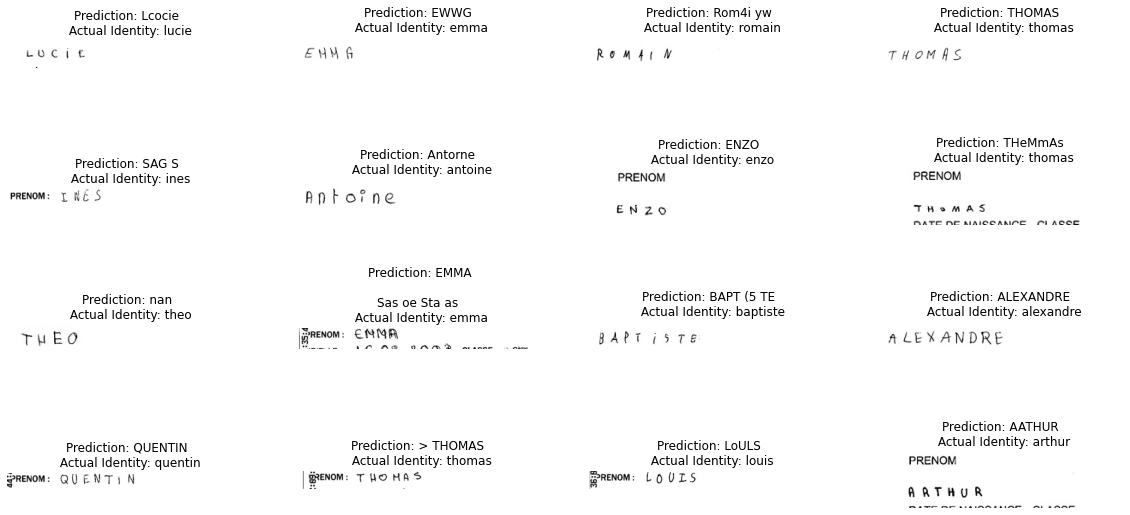

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(20, 10))
for i in range(16):
    img_dir = file_path_train+train_n_shape.loc[i, 'FILENAME']
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    title = f"Prediction: {result.loc[i,'prediction']} \n Actual Identity: {result.loc[i,'actual_identity']}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()